In [1]:
import numpy as np
import pandas as pd

from scipy import stats, special, spatial
from statsmodels.stats.multitest import multipletests
from statsmodels import robust
import importlib.util

import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [2]:
## datasets
folder = '../data/'

fn0 = 'Christoph_exp_v1.xlsx'
fn1 = 'SGD_features.tab'
fn2 = 'reg_region_sensitivity_analysis.csv'
fn3 = 'tfiid_genes_predictions_gfp.csv'

# model
#folder2 = '../../DeepExpression/results/2019_3_33/'
fname_data1 = folder+'data/scerevisiae.rsd1.lmbda_22.npz'
fname_module2 = folder+'models/Model_L2_C3F2addvarsopen_loadox.py'
fname_data2 = folder+'data/scerevisiae.rsd1.lmbda_22.1000.npz'
fname_p2 = folder+'scerevisiae_rsd1_merged_Model_C3F2_open_1241_0c6919106ab536108b55fd92965886b3_best.p'
fname_weights2 = folder+'scerevisiae_rsd1_merged_Model_C3F2_open_1241_0c6919106ab536108b55fd92965886b3_best'


In [3]:
## functions
def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

#https://stackoverflow.com/questions/30657453/fitting-a-straight-line-to-a-log-log-curve-in-matplotlib
def powerfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)

def perc_change(new,old):
    return (new-old)/old

# load modules - POC model
def load_module(model_path):
    '''loads module containing models given path'''
    spec = importlib.util.spec_from_file_location('module',model_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

def load_p(w_files):
    return [pd.read_csv(file,header=None,index_col=0)[1] for file in w_files]

def boxtpm(x, lmbda):
    return special.inv_boxcox(x, lmbda)

def coeff_determination(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true-y_pred))
    SS_tot = np.sum(np.square(y_true-np.mean(y_true)))
    return (1-SS_res/(SS_tot+1e-8))


## Construction and analysis of new models

### fig s6-1

In [4]:
## load data and model
module = load_module(fname_module2)

# load p
p = load_p([fname_p2])[0]

# load data
X_train, X_test, Y_train, Y_test = module.load_data(fname_data2)
Y = np.concatenate((Y_train, Y_test))
X = np.concatenate((X_train[0], X_test[0]))
Xcf = np.concatenate((X_train[1], X_test[1]))
print(X.shape)
print(Xcf.shape)

# model
input_shapes = [sl.shape[1:] for sl in X_train]
model = module.POC_model(input_shapes, p)
# set weights model 1
print("Loading model 1 from disk..")
model.load_weights(fname_weights2)


Using TensorFlow backend.


(4238, 1000, 4)
(4238, 64)
[<module 'module' from '/home/zrimec/projects/DeepExpression/results/2019_3_33/models/Model_C3F2dil.py'>]
Loading model 1 from disk..


In [5]:
# predict Ypred

Y_pred = model.predict(X_test)

0.7965045568548246


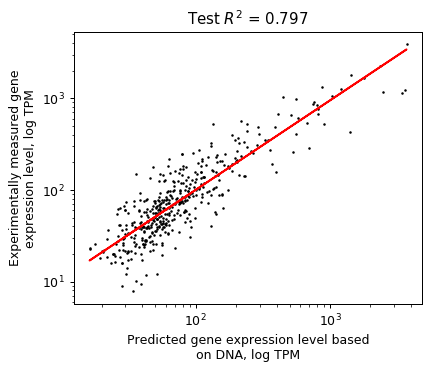

In [6]:
# scatter ypred ytrue
mpl.rcParams['figure.dpi'] = 90

print(coeff_determination(Y_test,Y_pred))

df_ys = pd.DataFrame([item for el in Y_test for item in el],columns=['ytrue'])
df_ys['ypred'] = [item for el in Y_pred for item in el]
df_ys.head()
r2 = coeff_determination(df_ys.ytrue.values,df_ys.ypred.values)

plt.figure(figsize=(5,4))
y = df_ys[df_ys > 0].dropna().ytrue.apply(boxtpm,lmbda=0.22).values
x = df_ys[df_ys > 0].dropna().ypred.apply(boxtpm,lmbda=0.22).values

plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')

plt.xscale('log')
plt.yscale('log')
# plt.xlim(-0.001,0.08)
# plt.ylim(-0.001,0.1)
plt.ylabel('Experimentally measured gene\nexpression level, log TPM')
plt.xlabel('Predicted gene expression level based\non DNA, log TPM')
plt.title('Test $R^2$ = '+str("%.3f" % r2))

plt.show()


### fig s6-2

In [7]:
dfp = pd.read_csv(folder+fn2)
print(dfp.shape)
dfp.head()

(415324, 5)


,relevance,y,region,abs_relevance,model
0,0.013213,Q4_high,"('Prom',)",0.013213,regions
1,0.040911,Q1_none,"('Prom',)",0.040911,regions
2,0.028244,Q3_medium,"('Prom',)",0.028244,regions
3,-0.007970,Q4_high,"('Prom',)",0.007970,regions
4,-0.329672,Q4_high,"('Prom',)",0.329672,regions


In [8]:
dfp.model.unique()

array(['regions', 'regions+cf', 'regions+cf_retrain', 'regions+gfp',
       '1000bp_regions', '1000bp_regions+cf_retrain',
       '1000bp_regions+gfp'], dtype=object)

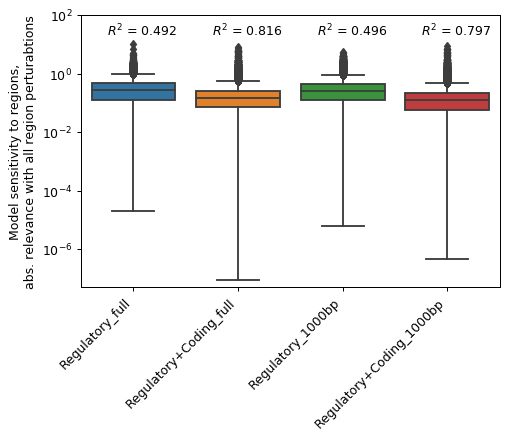

In [9]:
## plot boxplots of relevance distirbutions
# IE model sensitivity to regions

# annotate with: R2 of models, fold change medians
ann1 = [0.492,0.816,0.496,0.797]

# dfp['fold'] = 0
# for modell in dfp.model.unique():
#     print(modell)
#     dfp.at[dfp.model==modell,'fold'] = (dfp[dfp.model==modell]
#                                         .abs_relevance
#                                         .median()/dfp[dfp.model=='regions'].abs_relevance.median())
# # fix for last two
# for modell in dfp.model.unique()[-2:]:
#     print(modell)
#     dfp.at[dfp.model==modell,'fold'] = (dfp[dfp.model==modell]
#                                         .abs_relevance
#                                         .median()/dfp[dfp.model=='1000bp_regions'].abs_relevance.median())
# dfp.head()

g = sns.boxplot(x="model", y="abs_relevance", 
                data=dfp[dfp.model.isin(['regions',
                                         'regions+cf_retrain',
                                         '1000bp_regions',
                                         '1000bp_regions+cf_retrain'])]
               )
plt.ylim([5e-8,100])
plt.yscale('log')
k = -0.25
for ann in ann1:
    plt.annotate('$R^2$ = '+str(ann),[k,20])
    k+=1
k=0
plt.ylabel('Model sensitivity to regions,\nabs. relevance with all region perturabtions')
plt.xlabel('')
plt.xticks(ticks=[0,1,2,3],
           labels=['Regulatory_full','Regulatory+Coding_full','Regulatory_1000bp','Regulatory+Coding_1000bp'])
for item in g.get_xticklabels():
    item.set_rotation(45)
    item.set_horizontalalignment('right')

plt.show()


In [10]:
# state medians

(dfp[dfp.model.isin(['regions',
                     'regions+cf_retrain',
                     '1000bp_regions',
                     '1000bp_regions+cf_retrain'])]
 .groupby('model')
 .median()
#  .abs_relevance
#  .values
)


,relevance,abs_relevance
model,,
1000bp_regions,0.109423,0.258605
1000bp_regions+cf_retrain,0.000463,0.121922
regions,-0.123058,0.269423
regions+cf_retrain,0.040298,0.150839


## fig s6-3

In [11]:
df_gfp = pd.read_csv(folder+fn3)
df_gfp.head()


,gene_id,group,y,ytpm,xhot,xcf,ypred_gfp,ypred_gfptag,ypred_gfp_tpm,ypred_gfptag_tpm,dist_xcf_gfp,dist_xcf_gfptag,change_gfp,change_gfptag,ypred,ypred_tpm
0,YLR410W,TFIID-dominated,8.677561,128.223900,[[1 0 0 0]\n [1 0 0 0]\n [0 0 1 0]\n ...\n [1 ...,[63 34 50 33 12 13 9 24 26 8 8 20 21 14 29 ...,7.795843,8.615527,93.700770,125.512276,144.398753,132.049233,0.101609,0.007149,8.134313,105.963030
1,YMR177W,TFIID-dominated,5.185425,31.813583,[[0 0 0 1]\n [0 0 1 0]\n [1 0 0 0]\n ...\n [0 ...,[18 12 14 21 6 5 6 11 7 2 3 8 18 15 5 ...,6.007339,6.744857,45.992000,62.522910,54.230987,48.135226,0.158505,0.300734,5.118769,30.834990
2,YGL201C,TFIID-dominated,6.975679,68.547310,[[0 0 0 1]\n [1 0 0 0]\n [0 1 0 0]\n ...\n [0 ...,[23 19 26 32 24 6 10 20 37 10 12 26 14 14 24 ...,5.475202,6.160033,36.352993,49.095474,129.506757,118.093184,0.215101,0.116927,7.025702,69.910590
3,YER094C,TFIID-dominated,10.922983,261.569430,[[1 0 0 0]\n [0 0 1 0]\n [0 0 0 1]\n ...\n [0 ...,[ 2 4 11 3 1 3 2 4 4 2 1 3 1 7 5 ...,9.833305,10.363860,187.664600,221.263990,28.106939,34.058773,0.099760,0.051188,11.024610,269.472300
4,YPL161C,TFIID-dominated,5.039734,29.705265,[[0 0 0 1]\n [1 0 0 0]\n [0 0 0 1]\n ...\n [1 ...,[29 15 16 32 9 7 7 8 10 11 2 12 19 14 11 ...,6.709591,7.455874,61.640114,82.527770,71.707740,63.039670,0.331338,0.479418,5.197906,31.999485


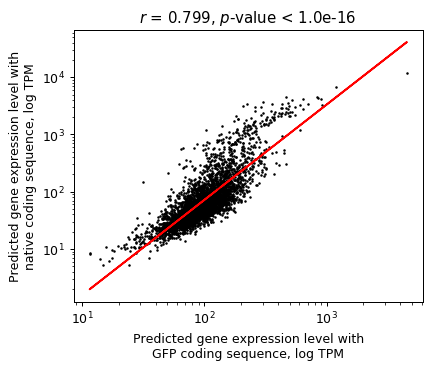

In [12]:
# log scale plot

plt.figure(figsize=(5,4))
x = df_gfp.ypred_gfptag_tpm.values
y = df_gfp.ypred_tpm.values

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')

plt.xscale('log')
plt.yscale('log')
# plt.xlim(-0.001,0.08)
# plt.ylim(-0.001,0.1)
plt.ylabel('Predicted gene expression level with\nnative coding sequence, log TPM')
plt.xlabel('Predicted gene expression level with\nGFP coding sequence, log TPM')
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))

plt.show()


30.199337741083003


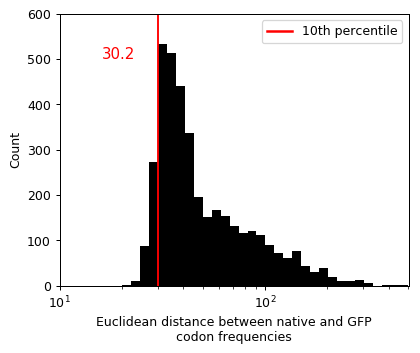

In [13]:
plt.figure(figsize=(5,4))
# plt.hist(df_gfp.dist_xcf_gfptag,bins=40,color='k')
# plt.title('distance gene to gfp c.f.')
# plt.legend(['gfp','gfptag'])
# plt.show()

# 10 percentile
dist_xcf_gfptag_10p = df_gfp.dist_xcf_gfptag.quantile(q=0.1)
print(dist_xcf_gfptag_10p)

bmin, bmax = 10, 500
logbins = 10 ** np.linspace(np.log10(bmin), np.log10(bmax), 40)
#df_gfp.dist_xcf_gfptag.hist(bins = logbins,color='k')
plt.hist(df_gfp.dist_xcf_gfptag,bins=logbins,color='k')
plt.xscale('log')
plt.xlim(bmin,bmax)
plt.ylim(0,600)
plt.xlabel('Euclidean distance between native and GFP\ncodon frequencies')
plt.ylabel('Count')
#plt.grid(None)

plt.plot([dist_xcf_gfptag_10p,dist_xcf_gfptag_10p],[0,600],'r')
plt.annotate('%.1f'%(dist_xcf_gfptag_10p),xy=(16,500),
            color='r',size=12)

custom_lines = [Line2D([0], [0], color='r', lw=2)]
plt.legend(custom_lines,['10th percentile'])

plt.show()


0.04185034010000001


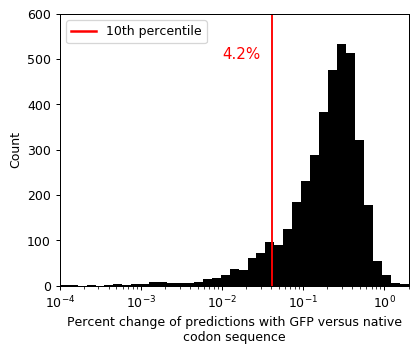

In [14]:
plt.figure(figsize=(5,4))
# plt.hist(df_gfp.dist_xcf_gfptag,bins=40,color='k')
# plt.title('distance gene to gfp c.f.')
# plt.legend(['gfp','gfptag'])
# plt.show()

# 10 percentile
change_gfptag_10p = df_gfp.change_gfptag.quantile(q=0.1) 
print(change_gfptag_10p)

bmin, bmax = 0.0001, 2
logbins = 10 ** np.linspace(np.log10(bmin), np.log10(bmax), 40)
#df_gfp.dist_xcf_gfptag.hist(bins = logbins,color='k')
plt.hist(df_gfp.change_gfptag,bins=logbins,color='k')
plt.xscale('log')
plt.xlim(bmin,bmax)
plt.ylim(0,600)
plt.xlabel('Percent change of predictions with GFP versus native\ncodon sequence')
plt.ylabel('Count')
#plt.grid(None)

plt.plot([change_gfptag_10p,change_gfptag_10p],[0,600],'r')
plt.annotate('%.1f'%(change_gfptag_10p*100)+'%',xy=(0.01,500),
            color='r',size=12)

custom_lines = [Line2D([0], [0], color='r', lw=2)]
plt.legend(custom_lines,['10th percentile'],loc=0)

plt.show()


(52, 16)


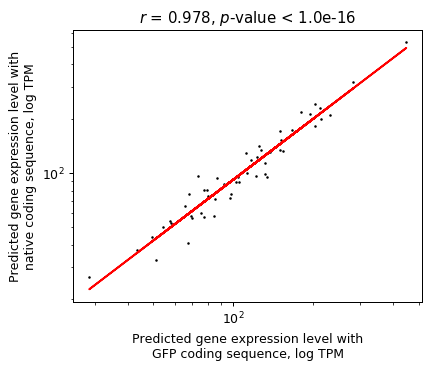

In [15]:
# 10th percentile 

print(df_gfp[(df_gfp.dist_xcf_gfptag<=dist_xcf_gfptag_10p)&
            (df_gfp.change_gfptag<=change_gfptag_10p)].shape)

plt.figure(figsize=(5,4))
x = (df_gfp[(df_gfp.dist_xcf_gfptag<=dist_xcf_gfptag_10p)&
            (df_gfp.change_gfptag<=change_gfptag_10p)]
     .ypred_gfptag_tpm
     .values
    )
y = (df_gfp[(df_gfp.dist_xcf_gfptag<=dist_xcf_gfptag_10p)&
            (df_gfp.change_gfptag<=change_gfptag_10p)]
     .ypred_tpm
     .values
    )

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')

plt.xscale('log')
plt.yscale('log')
# plt.xlim(-0.001,0.08)
# plt.ylim(-0.001,0.1)
plt.ylabel('Predicted gene expression level with\nnative coding sequence, log TPM')
plt.xlabel('Predicted gene expression level with\nGFP coding sequence, log TPM')
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))

plt.show()


## Correlations

In [16]:
# load data

df = (pd
      .read_excel(folder+fn0, sheet_name='Sheet1')
      .drop(columns=['Index'])
      .melt(id_vars=['Promoter'], 
        value_vars=['Native Terminator','Weak Terminator (YPR153W)','Strong Terminator (YLR167W)'])
      .rename(columns={'variable':'Terminator','value':'GFP_FI'})
     )
df['Prediction'] = (pd
      .read_excel(folder+fn0, sheet_name='Sheet1')
      .drop(columns=['Index'])
      .melt(id_vars=['Promoter'], 
        value_vars=['Native','Weak','Strong'])
      .value
     )

df['Prom_name'] = df.Promoter.apply(lambda x: x.split(' - ')[1])
df['Prom_id'] = df.Promoter.apply(lambda x: x.split(' - ')[0])
df['Term_id'] = df.Terminator.apply(lambda x: ''.join(x.split(' ')[-1]).strip('(').strip(')'))
df['Terminator'] = df.Terminator.apply(lambda x: ''.join(x.split(' ')[0]))

df['model_acc'] = 'good'
df.at[df.Prom_id.isin(['YGR030C','YOR063W']),'model_acc'] = 'weak'

df.head()


,Promoter,Terminator,GFP_FI,Prediction,Prom_name,Prom_id,Term_id,model_acc
0,YDR541C - L1,Native,1.930,28.651520,L1,YDR541C,Terminator,good
1,YGR030C - L2,Native,2.890,63.628162,L2,YGR030C,Terminator,weak
2,YKL128C - M1,Native,2.945,84.671318,M1,YKL128C,Terminator,good
3,YBL036C - M2,Native,4.225,111.754456,M2,YBL036C,Terminator,good
4,YPL050C - M3,Native,12.000,150.403610,M3,YPL050C,Terminator,good


In [17]:
# merge on SGD gene names

# import wget
# url = 'https://downloads.yeastgenome.org/curation/chromosomal_feature/SGD_features.tab'
# fname = wget.download(url)
columns = ['Primary SGDID (mandatory)',
           'Feature type (mandatory)',
            'Feature qualifier (optional)',
            'Feature name',
            'Standard gene name (optional)',
            'Alias (optional, multiples separated by |)',
            'Parent feature name (optional)',
            'Secondary SGDID (optional, multiples separated by |)',
            'Chromosome (optional)',
            'Start_coordinate (optional)',
            'Stop_coordinate (optional)',
            'Strand (optional)',
            'Genetic position (optional)',
            'Coordinate version (optional)',
            'Sequence version (optional)',
            'Description']
gene_function = (pd
                 .read_csv(folder+fn1,sep='\t',header=None,names=columns)
                 .set_index('Feature name')
                )
gene_function.head()

# merge sgd frame
df['Promoter'] = (gene_function
                  .loc[df.Prom_id]['Standard gene name (optional)']
                  .values
                 )
df['Promoter'] = df['Promoter'].fillna(df['Prom_id'])
# df['Term_id2'] = (gene_function
#                   .loc[df.Term_id]['Standard gene name (optional)']
#                   .values
#                  )
# df['Term_id2'] = df['Term_id2'].fillna(df['Term_id'])
df.tail()


,Promoter,Terminator,GFP_FI,Prediction,Prom_name,Prom_id,Term_id,model_acc
19,YBL036C,Strong,1.885,433.951915,M2,YBL036C,YLR167W,good
20,MNN9,Strong,15.850,564.829720,M3,YPL050C,YLR167W,good
21,RPC40,Strong,19.150,504.765245,M4,YPR110C,YLR167W,good
22,HIS1,Strong,68.700,880.933229,H1,YER055C,YLR167W,good
23,RPL3,Strong,187.000,1284.716994,H2,YOR063W,YLR167W,weak


-0.8841277588913368


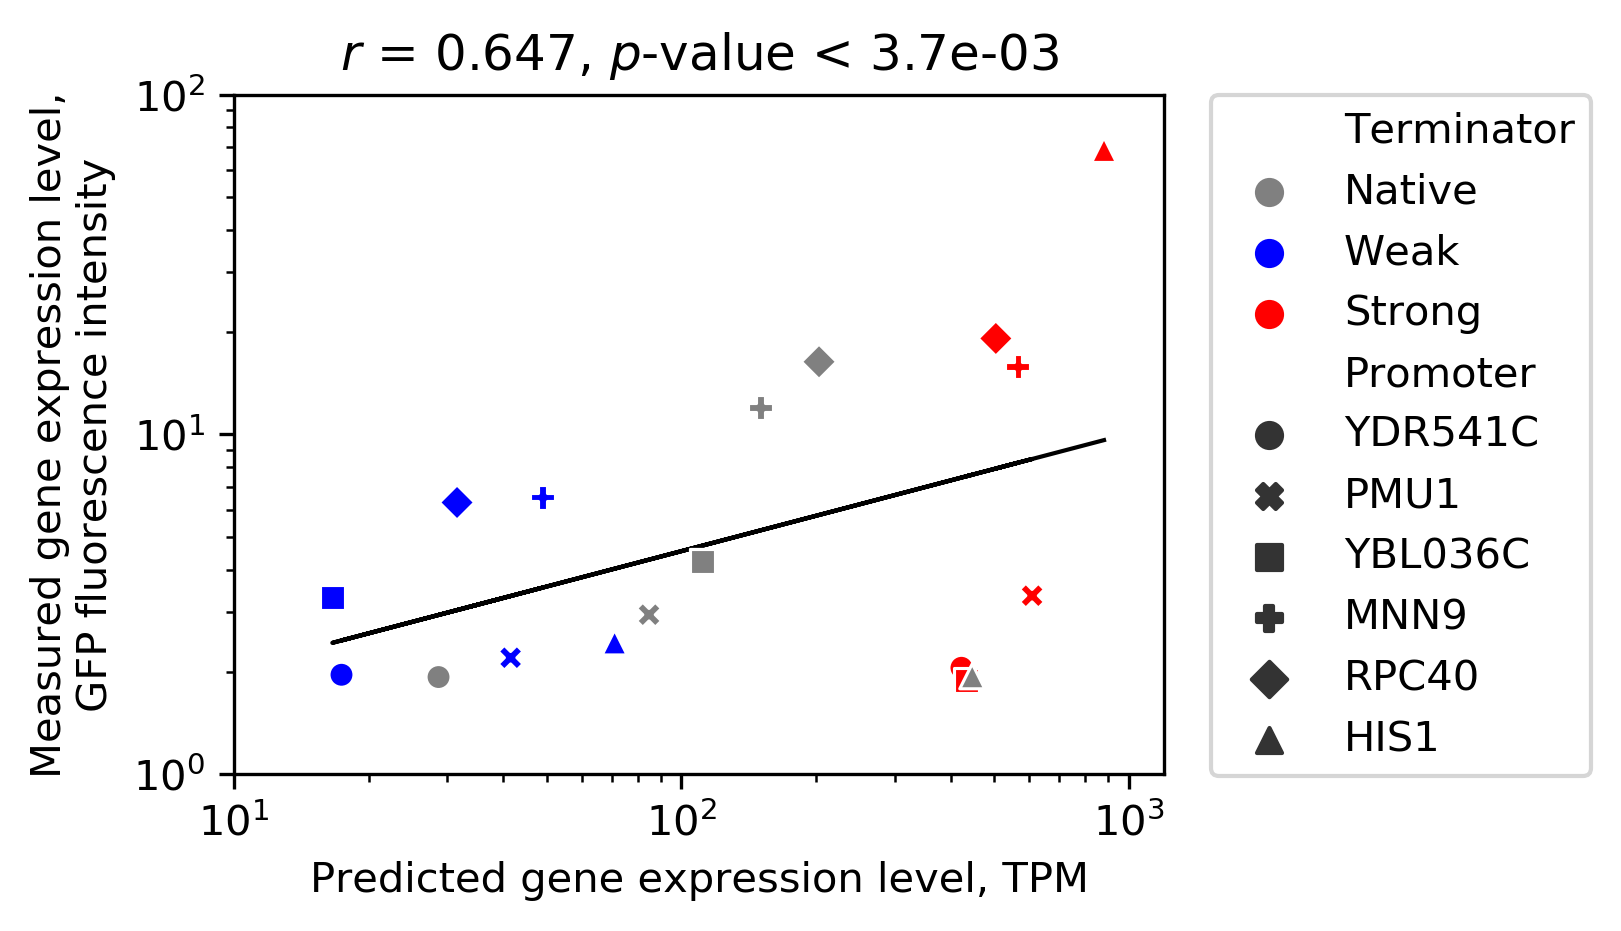

In [18]:
# Correlations

mpl.rcParams['figure.dpi'] = 300

plt.figure(figsize=(4,3))
x = df[df.model_acc=='good'].Prediction
y = df[df.model_acc=='good'].GFP_FI

slope1, intercept1, rvalue, pvalue, stderr = stats.linregress(x,y)

sns.scatterplot(data=df[(df.model_acc=='good')],y='GFP_FI',x='Prediction', #&(df.Promoter=='YER055C - H1')
                style='Promoter',hue='Terminator',palette=['grey','b','r']) #,y_jitter=1000)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# replot native to be on top
sns.scatterplot(data=df[(df.model_acc=='good')&(df.Terminator=='Native')],
                y='GFP_FI',x='Prediction', 
                style='Promoter',color='grey',legend=False)

plt.plot(x, powerfit(x,y,x), 'k',label='_nolegend_', #label='fitted line',
        linewidth=1,zorder=0)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1,100)
plt.xlim(10,1200)

plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))
plt.ylabel('Measured gene expression level,\nGFP fluorescence intensity')
plt.xlabel('Predicted gene expression level, TPM')

print(coeff_determination(x, y))

plt.savefig('f6b.svg')


In [19]:
# Amount of improvement of model prediction low vs high
# based on experimental data = RMSE_high/RMSE_low

from sklearn import metrics

print(np.sqrt(metrics.mean_squared_error(df[df.Terminator=='Strong'].GFP_FI,
                           df[df.Terminator=='Strong'].Prediction))/
np.sqrt(metrics.mean_squared_error(df[df.Terminator=='Weak'].GFP_FI,
                           df[df.Terminator=='Weak'].Prediction)))

print((coeff_determination(df[df.Terminator=='Strong'].GFP_FI,
                           df[df.Terminator=='Strong'].Prediction))/
(coeff_determination(df[df.Terminator=='Weak'].GFP_FI,
                           df[df.Terminator=='Weak'].Prediction)))

print(coeff_determination(df[df.Terminator=='Weak'].GFP_FI,
                           df[df.Terminator=='Weak'].Prediction))
print(coeff_determination(df[df.Terminator=='Strong'].GFP_FI,
                           df[df.Terminator=='Strong'].Prediction))

18.585769916618077
54.27032881514763
-2.0903286283899036
-113.4428219944366


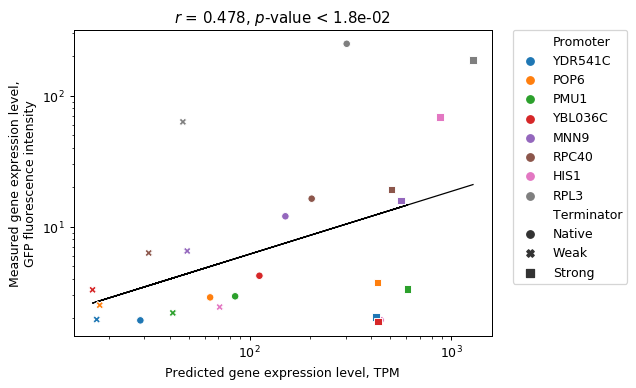

In [20]:
# adding known promoters with larger GFP deviation

mpl.rcParams['figure.dpi'] = 90

plt.figure(figsize=(6,4.5))
x = df.Prediction
y = df.GFP_FI

slope1, intercept1, rvalue, pvalue, stderr = stats.linregress(x,y)

sns.scatterplot(data=df,y='GFP_FI',x='Prediction',
                hue='Promoter',style='Terminator')

plt.plot(x, powerfit(x,y,x), 'k',label='_nolegend_', #label='fitted line',
        linewidth=1,zorder=0)
plt.xscale('log')
plt.yscale('log')

plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))
plt.ylabel('Measured gene expression level,\nGFP fluorescence intensity')
plt.xlabel('Predicted gene expression level, TPM')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [21]:
# save order
order = (df[(df.model_acc=='good')
            &(df.Terminator=='Native')]
         .sort_values(by='Prediction')
         .Promoter
         .values
        )
order

array(['YDR541C', 'PMU1', 'YBL036C', 'MNN9', 'RPC40', 'HIS1'],
      dtype=object)

## Percentage changes

In [22]:
# load data

df = pd.read_excel(folder+fn0, sheet_name='Sheet2')
df = df.iloc[:-2]

conv = pd.read_excel(folder+fn0, sheet_name='Naming',
                     header=None,names=['name','ind','gene_id'])
conv

df['prom_ind'] = df.Strain.apply(lambda x: x.split('-')[0]).astype(int)
df['term_ind'] = df.Strain.apply(lambda x: x.split('-')[1]).astype(int)
df.head()

df = (df
       .merge(conv,left_on='prom_ind',right_on='ind',how='left')
       .rename(columns={'name':'Prom_name','gene_id':'Prom_id'})
       .merge(conv,left_on='term_ind',right_on='ind',how='left')
       .rename(columns={'name':'Term_name','gene_id':'Term_id'})
       .drop(columns=['ind_x','ind_y','prom_ind','term_ind'])
      )
df

df['model_acc'] = 'good'
df.at[df.Prom_id.isin(['YGR030C','YOR063W']),'model_acc'] = 'weak'

# merge sgd frame
df['Promoter'] = (gene_function
                  .loc[df.Prom_id]['Standard gene name (optional)']
                  .values
                 )
df['Promoter'] = df['Promoter'].fillna(df['Prom_id'])
# df['Term_id2'] = (gene_function
#                   .loc[df.Term_id]['Standard gene name (optional)']
#                   .values
#                  )
# df['Term_id2'] = df['Term_id2'].fillna(df['Term_id'])

# define terminator columns
df['Terminator'] = 'Native'
df.at[df.Term_name=='Weak Terminator','Terminator'] = 'Weak'
df.at[df.Term_name=='Strong Terminator','Terminator'] = 'Strong'

df.head()

,Strain,Replicate,Well ID,Mean GFP,Median GFP,SD GFP,Prom_name,Prom_id,Term_name,Term_id,model_acc,Promoter,Terminator
0,2-2,1,A01,3.25,2.84,2.28,Weak Promoter,YGR030C,Weak Promoter,YGR030C,weak,POP6,Native
1,2-1,1,A02,2.92,2.57,1.49,Weak Promoter,YGR030C,Weak Terminator,YPR153W,weak,POP6,Weak
2,2-3,1,A03,4.29,3.69,3.23,Weak Promoter,YGR030C,Strong Terminator,YLR167W,weak,POP6,Strong
3,4-4,1,A04,5.25,4.27,3.83,M2,YBL036C,M2,YBL036C,good,YBL036C,Native
4,4-1,1,A05,3.89,3.41,2.08,M2,YBL036C,Weak Terminator,YPR153W,good,YBL036C,Weak


In [23]:
# Percentage change - around 0 so cannot be plotted log scale
for term in df.Terminator.unique():
    df.at[df.Terminator==term,'pc_gfp'] = (df.loc[df.Terminator==term,'Median GFP']
                                                    .subtract(df.loc[df.Terminator=='Native','Median GFP'].values)
                                                    .divide(df.loc[df.Terminator=='Native','Median GFP'].values)
                                                    #.apply(lambda x: np.log(x+1))              
                                           )
    
    
# # Fold change - is around 1 so cannot be plotted with barplot
# for term in df.Terminator.unique():
#     df.at[df.Terminator==term,'pc_gfp'] = (df.loc[df.Terminator==term,'Median GFP']
#                                                     .divide(df.loc[df.Terminator=='Native','Median GFP'].values)
#                                                                   )
df #.head()


,Strain,Replicate,Well ID,Mean GFP,Median GFP,SD GFP,Prom_name,Prom_id,Term_name,Term_id,model_acc,Promoter,Terminator,pc_gfp
0,2-2,1,A01,3.25,2.84,2.28,Weak Promoter,YGR030C,Weak Promoter,YGR030C,weak,POP6,Native,0.000000
1,2-1,1,A02,2.92,2.57,1.49,Weak Promoter,YGR030C,Weak Terminator,YPR153W,weak,POP6,Weak,-0.095070
2,2-3,1,A03,4.29,3.69,3.23,Weak Promoter,YGR030C,Strong Terminator,YLR167W,weak,POP6,Strong,0.299296
3,4-4,1,A04,5.25,4.27,3.83,M2,YBL036C,M2,YBL036C,good,YBL036C,Native,0.000000
4,4-1,1,A05,3.89,3.41,2.08,M2,YBL036C,Weak Terminator,YPR153W,good,YBL036C,Weak,-0.201405
5,4-3,1,A06,2.17,1.91,1.50,M2,YBL036C,Strong Terminator,YLR167W,good,YBL036C,Strong,-0.552693
6,5-5,1,A07,13.80,11.70,8.25,M3,YPL050C,M3,YPL050C,good,MNN9,Native,0.000000
7,5-1,1,A08,7.51,6.41,4.22,M3,YPL050C,Weak Terminator,YPR153W,good,MNN9,Weak,-0.452137
8,5-3,1,A09,18.40,15.70,10.10,M3,YPL050C,Strong Terminator,YLR167W,good,MNN9,Strong,0.341880
9,6-6,1,A10,2.24,1.99,1.34,H,YER055C,H,YER055C,good,HIS1,Native,0.000000


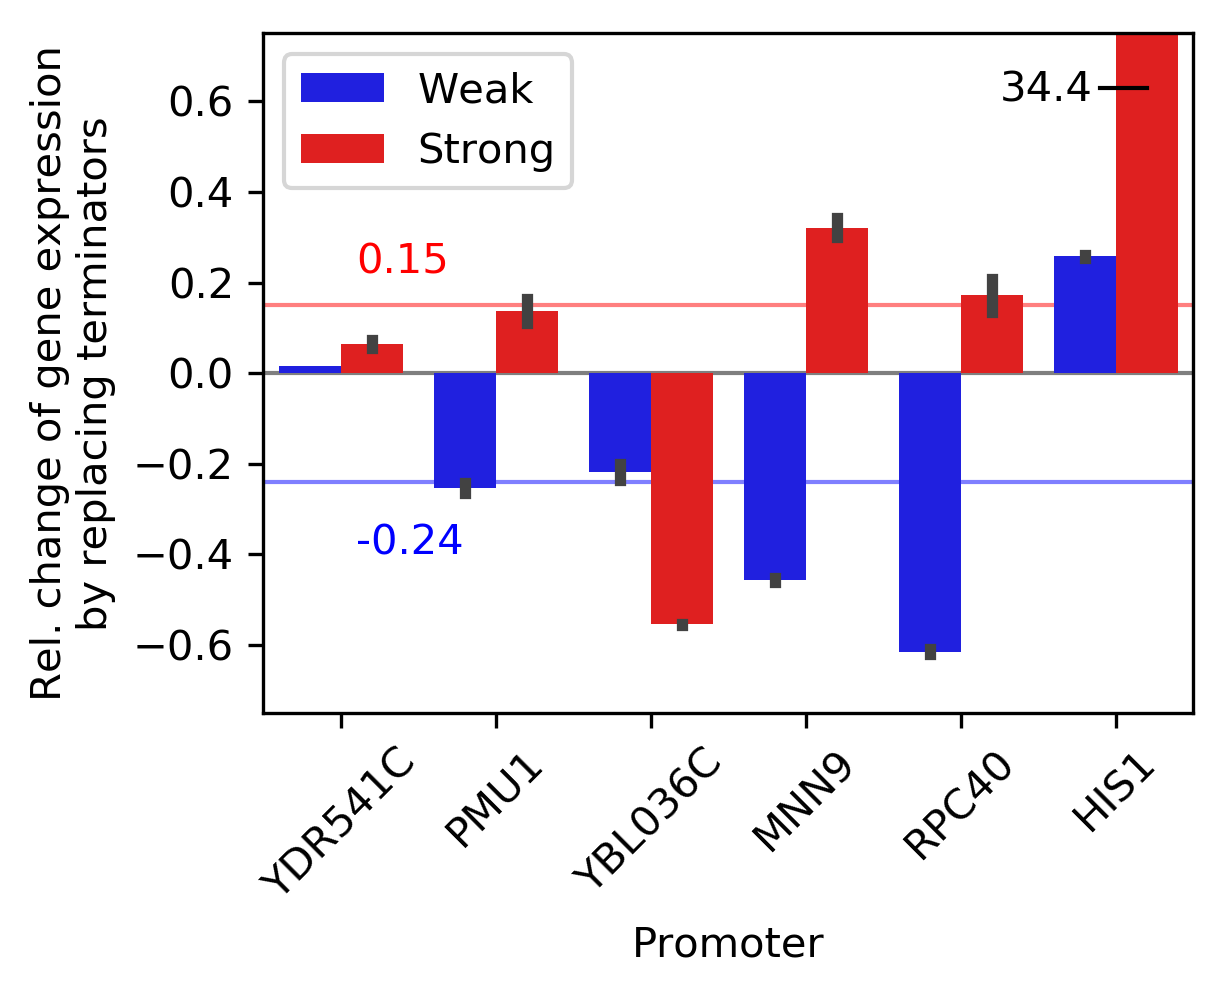

In [24]:
# barplot around native line increase decrese

mpl.rcParams['figure.dpi'] = 300

plt.figure(figsize=(4,3))

data = df[~(df.Terminator=='Native')&
                   (df.model_acc=='good')]

sns.barplot(data=data,x='Promoter',y='pc_gfp',
               hue='Terminator', palette=['b','r'],
           order=order,ci='sd')

# Put the legend out of the figure
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(loc=2)
plt.xticks(rotation=45)

# baseline
plt.plot([-1,10],[0,0],'k',zorder=0,
        linewidth = 1, alpha=0.5)

ann = df[df.model_acc=='good'].groupby('Terminator').pc_gfp.median().values[1]
plt.plot([-1,10],[ann,ann],'r',zorder=0,
        linewidth = 1, alpha=0.5)
plt.annotate(str(np.round(ann,3)),xy=(0.1,0.22),color='r')
ann = df[df.model_acc=='good'].groupby('Terminator').pc_gfp.median().values[2]
plt.plot([-1,10],[ann,ann],'b',zorder=0,
        linewidth = 1, alpha=0.5)
plt.annotate(str(np.round(ann,3)),xy=(0.1,-0.4),color='b')

ann = (df[(df.model_acc=='good')
          &(df.Promoter=='HIS1')
          &(df.Terminator=='Strong')]
       .pc_gfp
       .mean()
      )
plt.annotate(str(np.round(ann,1)),xy=(4.25,0.6),color='k')
plt.plot([4.9,5.2],[0.63,0.63],'k',linewidth=1)

plt.xlim(-0.5,5.5)
plt.ylim(-0.75,0.75)
plt.ylabel('Rel. change of gene expression\nby replacing terminators')

plt.savefig('f6c.svg')


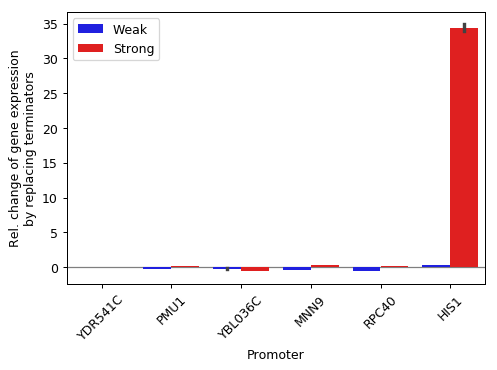

In [25]:
# Full figure 6C for supplementary

mpl.rcParams['figure.dpi'] = 90

#plt.figure(figsize=(4,3))

data = df[~(df.Terminator=='Native')&
                   (df.model_acc=='good')]

sns.barplot(data=data,x='Promoter',y='pc_gfp',
               hue='Terminator', palette=['b','r'],
           order=order,ci='sd')

# Put the legend out of the figure
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(loc=2)
plt.xticks(rotation=45)

# baseline
plt.plot([-1,10],[0,0],'k',zorder=0,
        linewidth = 1, alpha=0.5)

plt.xlim(-0.5,5.5)
#plt.ylim(-0.75,0.75)
plt.ylabel('Rel. change of gene expression\nby replacing terminators')
plt.show()


In [26]:
#We observed, on average, a corresponding X% change in GFP levels with all constructs

# this way combining both weak storng abs median is higher than individual..
df[(df.model_acc=='good')&
   (df.Terminator.isin(['Weak','Strong']))].pc_gfp.abs().median()

# average of both
print(np.mean(df[df.model_acc=='good']
              .groupby('Terminator')
              .pc_gfp
              .median()
              .abs()
              .values[1:])
     )

# RPC40
print(df[(df.model_acc=='good')
         &(df.Promoter=='RPC40')
         &(df.Terminator=='Weak')]
       .pc_gfp
       .mean()
      )

0.1947700311323171
-0.6148603100891319


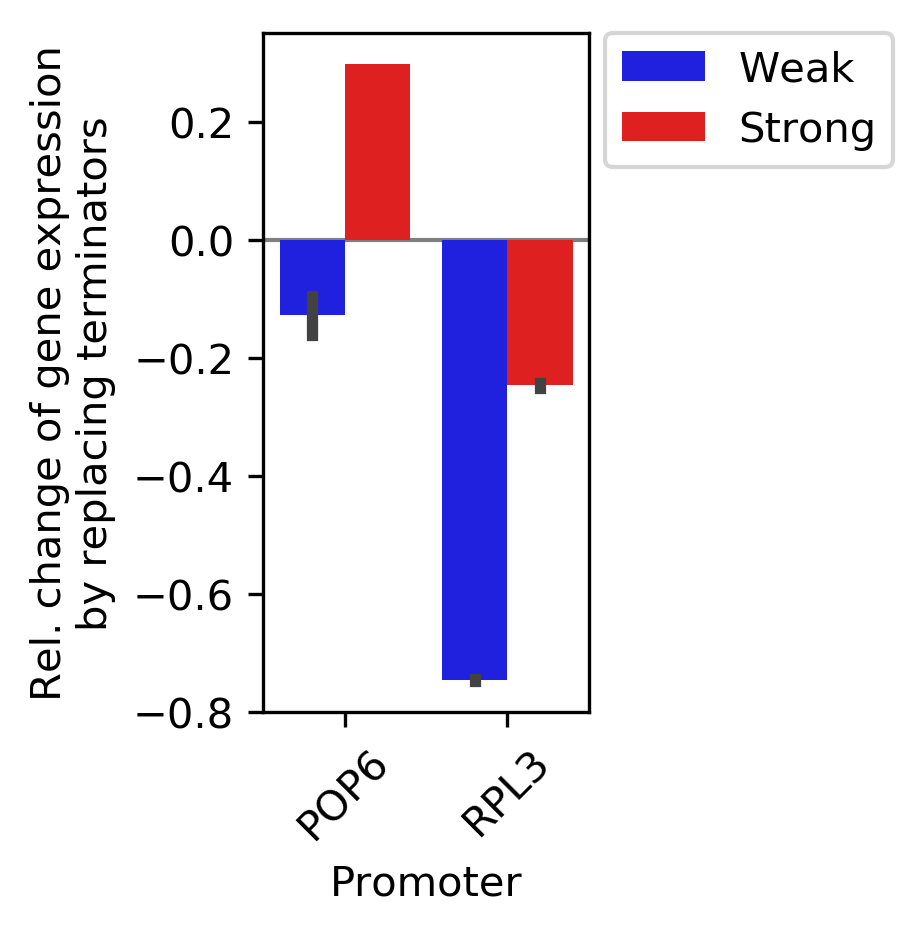

In [27]:
# barplot around native line increase decrese

mpl.rcParams['figure.dpi'] = 300

plt.figure(figsize=(1.4,3))

data = df[~(df.Terminator=='Native')&
                   (df.model_acc=='weak')]

sns.barplot(data=data,x='Promoter',y='pc_gfp',
               hue='Terminator', palette=['b','r'],
           ci='sd')
#plt.yscale('log')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)

# baseline
plt.plot([-1,10],[0,0],'k',zorder=0,
        linewidth = 1, alpha=0.5)

# ann = df[df.model_acc=='weak'].groupby('Terminator').pc_gfp.median().values[1]
# plt.plot([-1,10],[ann,ann],'b',zorder=0)
# plt.annotate(str(np.round(ann,3)),xy=(0.1,0.5),color='b')
# ann = df[df.model_acc=='weak'].groupby('Terminator').pc_gfp.median().values[2]
# plt.plot([-1,10],[ann,ann],'r',zorder=0)
# plt.annotate(str(np.round(ann,3)),xy=(0.1,-0.7),color='r')
plt.xlim(-0.5,1.5)
#plt.ylim(-3.1,0.5)

plt.ylabel('Rel. change of gene expression\nby replacing terminators')

plt.savefig('f6d.svg')


In [28]:
data = df[~(df.Terminator=='Native')&
                   (df.model_acc=='weak')]
data.groupby(['Promoter','Terminator']).pc_gfp.median()

Promoter  Terminator
POP6      Strong        0.299308
          Weak         -0.127467
RPL3      Strong       -0.245902
          Weak         -0.746198
Name: pc_gfp, dtype: float64

In [29]:
# difference high low
(df[df.Promoter.isin(['YDR541C','POP6'])]
 .groupby('Terminator')
 .pc_gfp
 .median()
 .divide(df[df.Promoter.isin(['HIS1','RPL3'])]
 .groupby('Terminator')
 .pc_gfp
 .median()
    )
)

print(np.abs((df[df.Terminator=='Weak']
 .groupby('Terminator')
 .pc_gfp
 .median()
 .values)/(df[df.Terminator=='Strong']
 .groupby('Terminator')
 .pc_gfp
 .median()
 .values)))

[1.5976507]
